# Song lyrics exploration - Part 3: Lexical diversity

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words

from nlp import tokenize

# Pre-processing

1. **Load data**

1. **Tokenize text data**

1. **Combine songs from same band**

1. **Split lyrics into words**

In [2]:
def get_genres(data):
    columns = [col for col in data.columns if 'genre_' in col]
    genres = [re.sub(r"^genre\_", "", col) for col in columns]
    return genres, columns


def get_bands(data):
    genres, genre_cols = get_genres(data)
    # Combine songs from same band
    band_genres = data.groupby('band_name')[genre_cols].max()
    band_lyrics = data.groupby('band_name').song_darklyrics.sum()
    bands = pd.concat((band_genres, band_lyrics), axis=1)
    bands.columns = genres + ['lyrics']
    bands['words'] = bands.lyrics.apply(tokenize)
    return bands


def get_songs(data):
    genres, genre_cols = get_genres(data)
    songs = data[genre_cols + ['song_darklyrics']].copy()
    songs.columns = genres + ['lyrics']
    songs['words'] = songs.lyrics.apply(tokenize)
    return songs

# Lexical diversity measures

$$
\begin{split}
&LD_{TTR} &= \frac{V}{N} &\hspace{1cm} (\textrm{type-token ratio})\\
&LD_{rootTTR} &= \frac{V}{\sqrt{N}} &\hspace{1cm} (\textrm{root type-token ratio})\\
&LD_{corrTTR} &= \frac{V}{\sqrt{2N}} &\hspace{1cm} (\textrm{corrected type-token ratio})\\
&LD_{logTTR} &= \frac{\log{V}}{\log{N}} &\hspace{1cm} (\textrm{logarithmic type-token ratio})\\
&LD_{dugast} &= \frac{(\log{N})^2}{\log{N} - \log{V}} &\hspace{1cm} (\textrm{Dugast uber index})
\end{split}
$$

In [3]:
def get_lexical_diversity(data):
    N = data.words.apply(len)
    V = data.words.apply(lambda x: len(set(x)))
    data['N'] = N
    data['V'] = V
    data['TTR'] = V / N
    data['rootTTR'] = V / np.sqrt(N)
    data['logTTR'] = np.log(V) / np.log(N)
    data['corrTTR'] = V / np.sqrt(2 * N)
    data['dugast'] = (np.log(N))**2 / (np.log(N) - np.log(V))
    return data

In [5]:
df = pd.read_csv('songs-10pct.csv')
df_bands = get_bands(df)
df_songs = get_songs(df)
df_bands = get_lexical_diversity(df_bands)
df_songs = get_lexical_diversity(df_songs)

D:\Anaconda3\envs\metallyrics\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Histograms

In [6]:
def plot_histograms(data):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of heavy metal artists", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    logNmin, logNmax = np.log10(data.N.min()), np.log10(data.N.max())
    logbins = np.logspace(logNmin, logNmax, 20)
    data.N.hist(bins=logbins, edgecolor='k', ax=ax)
    ax.set_xscale('log')
    ax.set_title("Vocabulary sizes")
    ax.set_xlabel("N (word count)")
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ax = axes[1]
    data.TTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")

    ax = axes[2]
    data.rootTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Root type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")

    ax = axes[3]
    data.corrTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Corrected type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{corrTTR}} = \sqrt{V/2N}$")

    ax = axes[4]
    data.logTTR.hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")

    ax = axes[5]
    data.dugast[data.dugast < np.inf].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Dugast uber index")
    ax.set_xlabel("$\mathrm{LD_{Dugast}} = (\log N)^2 / log(N/V)$")

    for ax in axes:
        ax.set_ylabel("Artists", rotation=0, labelpad=40)
        ax.grid(None)
        ax.grid(axis='y', color='k')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

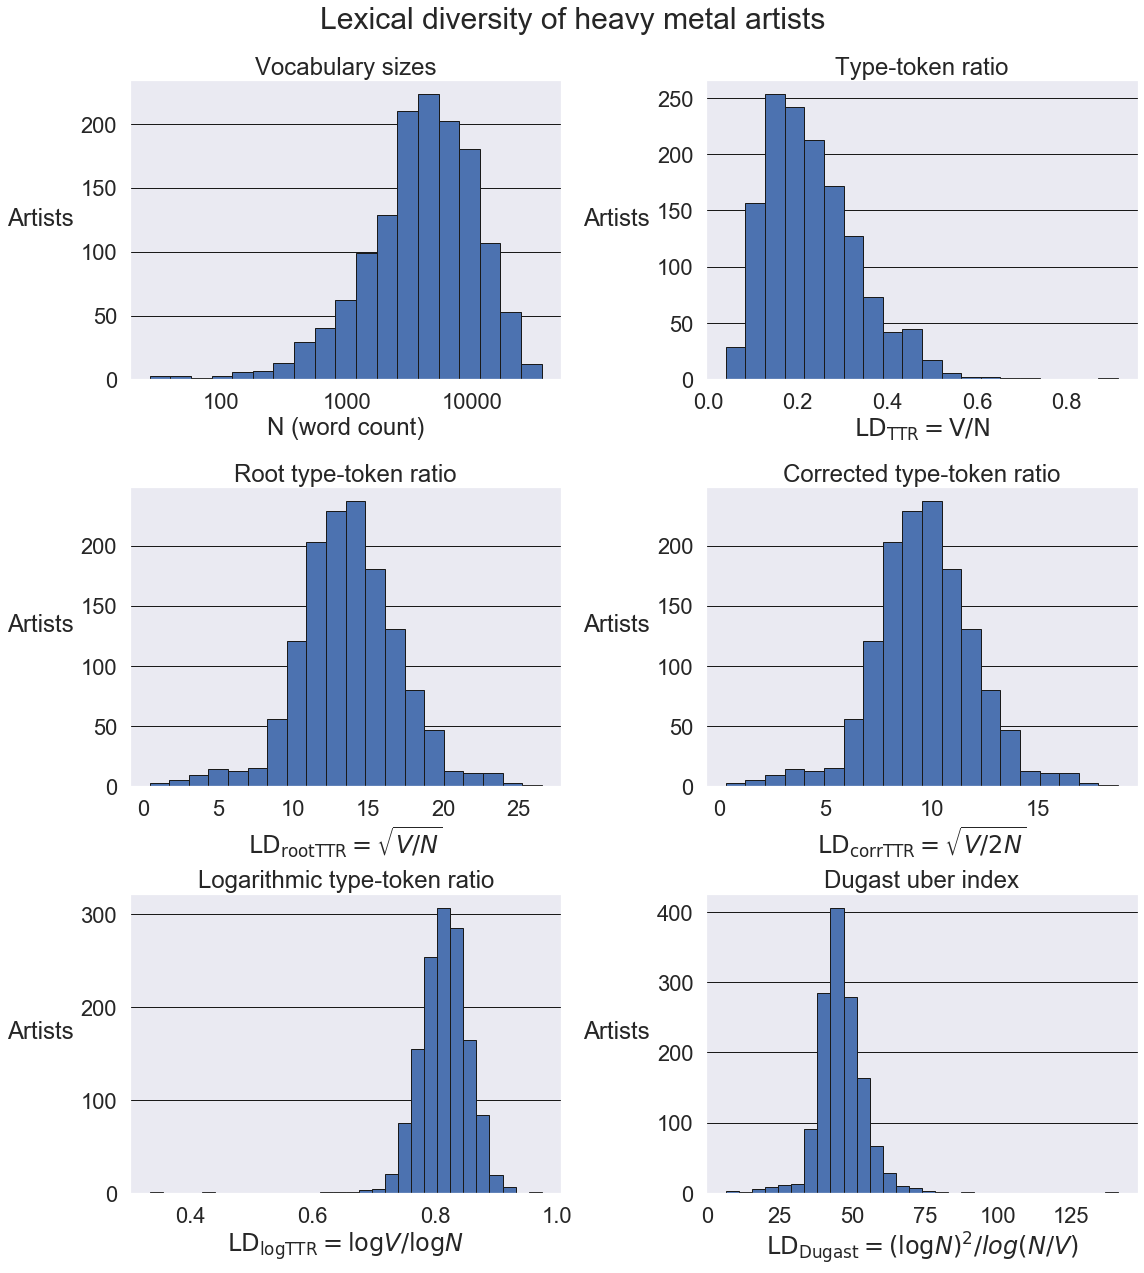

In [7]:
plot_histograms(df_bands)

# Box plots

In [8]:
def plot_boxplots(data):

    def boxplot(name, ax):
        boxdata = []
        labels = data.columns[:list(data.columns).index('lyrics')]
        for i, label in enumerate(labels):
            boxdata.append((label, data[data[label] > 0][name]))
        boxdata.sort(key=lambda x: x[1].median())
        ax.boxplot([x[1] for x in boxdata], vert=False, labels=[x[0] for x in boxdata], showfliers=False)
        return

    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    boxplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (word count)")

    ax = axes[1]
    boxplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (unique word count)")

    ax = axes[2]
    boxplot('TTR', ax)
    ax.set_title("type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
    boxplot('corrTTR', ax)
    ax.set_title("corrected type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{corrTTR}}$")

    ax = axes[4]
    boxplot('logTTR', ax)
    ax.set_title("logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[5]
    boxplot('dugast', ax)
    ax.set_title("Dugast uber index")
    ax.set_xlabel(r"$\mathrm{LD_{dugast}}$")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

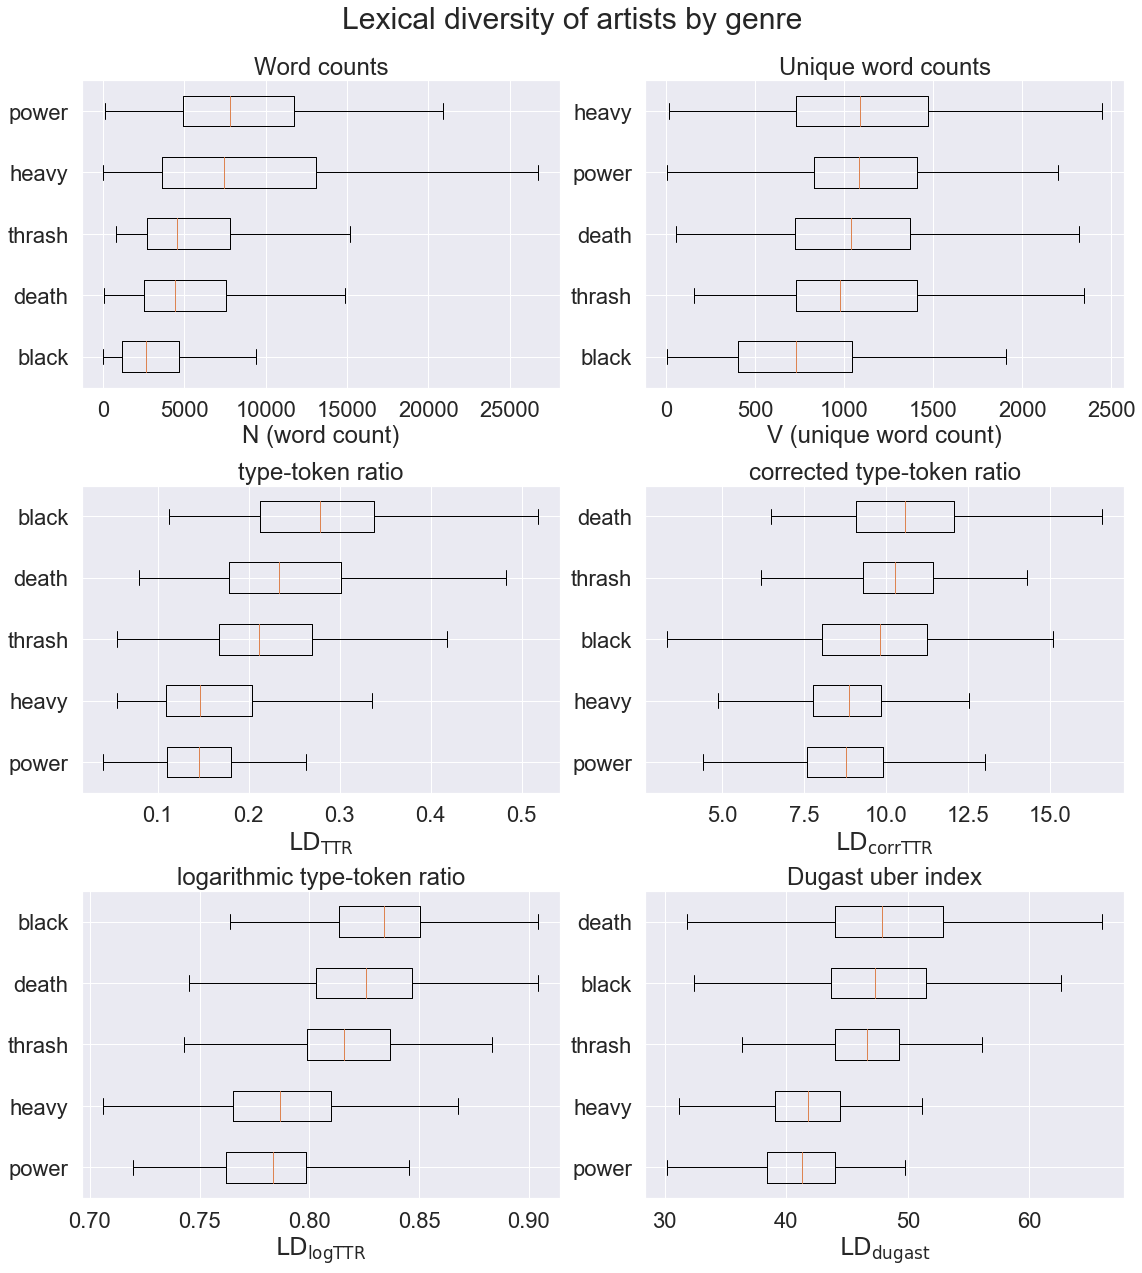

In [9]:
plot_boxplots(df_bands)

In [10]:
def plot_violinplots(data):

    def violinplot(col, ax):
        violindata = []
        labels = data.columns[:list(data.columns).index('lyrics')]
        for label in labels:
            violindata.append((label, data[data[label] == 1][col]))
        violindata.sort(key=lambda x: -x[1].median())
        plot_labels, plot_data = zip(*violindata)
        sns.violinplot(data=plot_data, cut=0, orient='h', ax=ax)
        ax.set_yticklabels(plot_labels)
        return

    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    violinplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (word count)")

    ax = axes[1]
    violinplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (unique word count)")

    ax = axes[2]
    violinplot('TTR', ax)
    ax.set_title("type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
    violinplot('corrTTR', ax)
    ax.set_title("corrected type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{corrTTR}}$")

    ax = axes[4]
    violinplot('logTTR', ax)
    ax.set_title("logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[5]
    violinplot('dugast', ax)
    ax.set_title("Dugast uber index")
    ax.set_xlabel(r"$\mathrm{LD_{dugast}}$")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

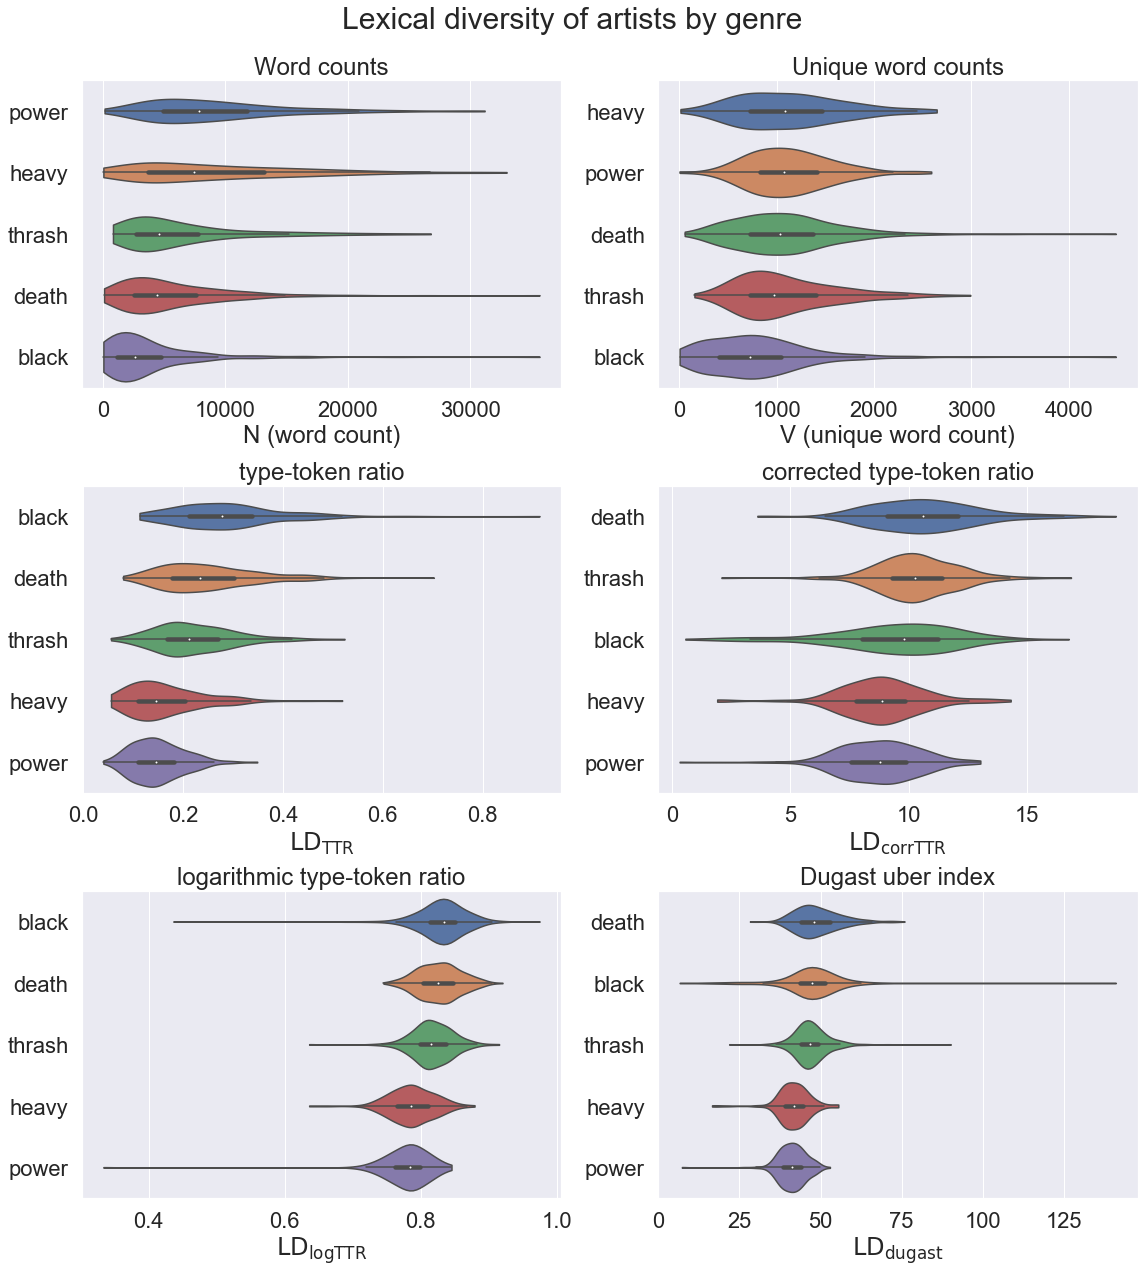

In [11]:
plot_violinplots(df_bands)

# Scatter plots

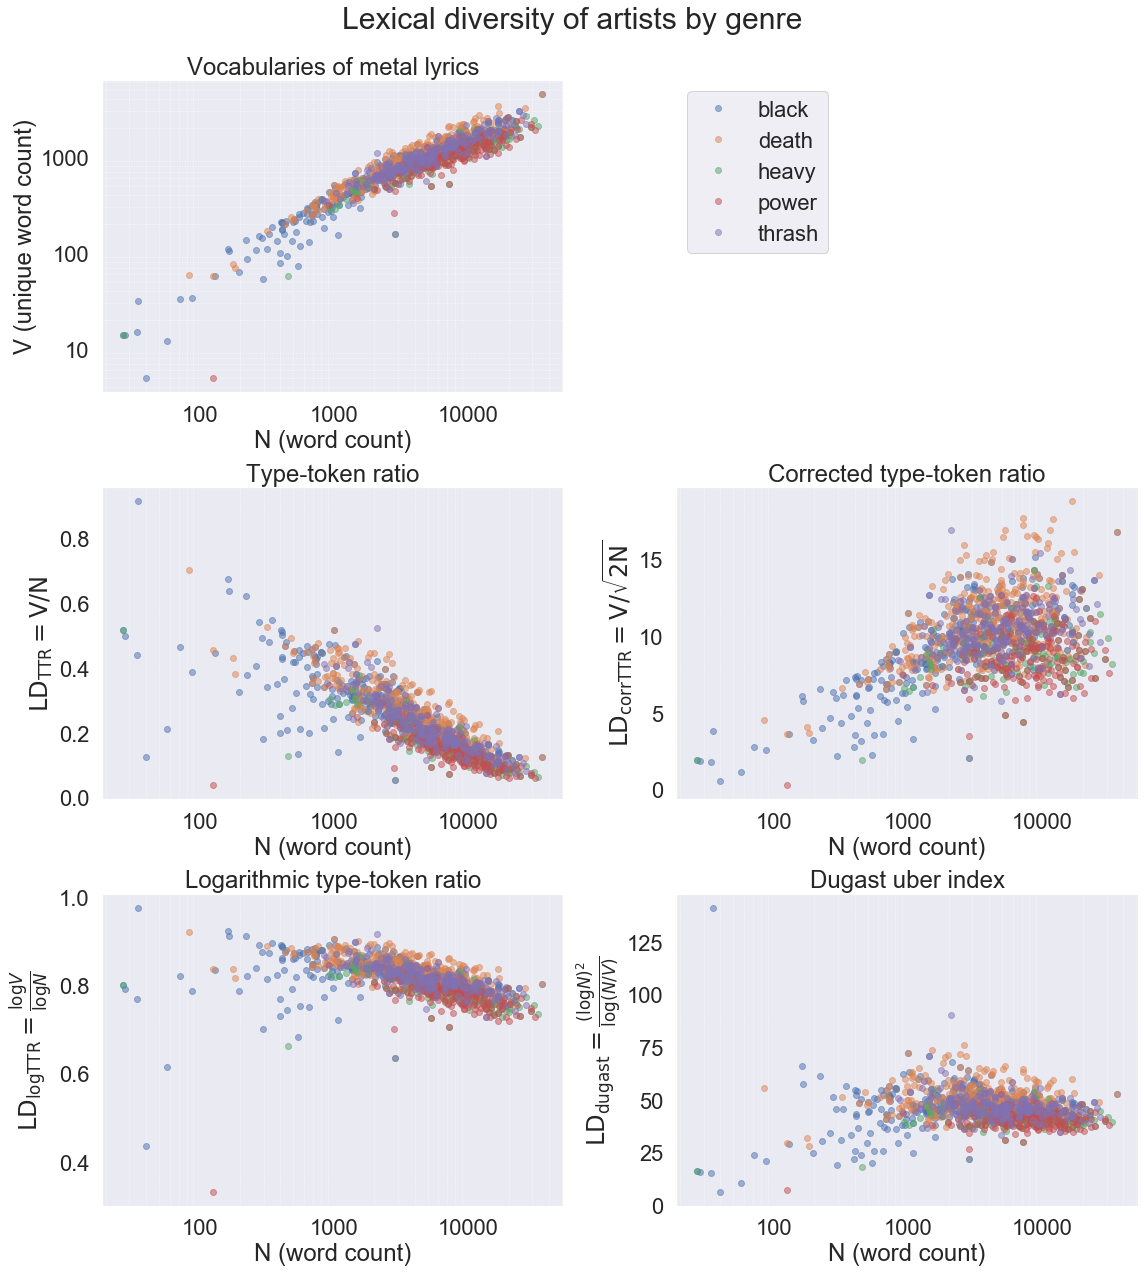

In [17]:
genres = df_bands.columns[:list(df_bands.columns).index('lyrics')]

def lexical_diversity_scatterplot(col, ax):
    for genre in genres:
        subset = df_bands[df_bands[genre] > 0]
        ax.plot(subset['N'], subset[col], 'o', markeredgewidth=1, alpha=0.5, label=genre)
    ax.set_xlabel("N (word count)")
    ax.grid(axis='both', which='major')
    ax.grid(axis='both', which='minor', ls=':', alpha=0.6)
    return

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
axes = axes.flatten()

ax = axes[0]
lexical_diversity_scatterplot('V', ax)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_ylabel("V (unique word count)")

ax = axes[1]
ax.axis('off')
for genre in genres:
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
lexical_diversity_scatterplot('TTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Type-token ratio")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")

ax = axes[3]
lexical_diversity_scatterplot('corrTTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Corrected type-token ratio")
ax.set_ylabel("$\mathrm{LD_{corrTTR} = V/\sqrt{2N}}$")

ax = axes[4]
lexical_diversity_scatterplot('logTTR', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Logarithmic type-token ratio")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")

ax = axes[5]
lexical_diversity_scatterplot('dugast', ax)
ax.set_xscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Dugast uber index")
ax.set_ylabel(r"$\mathrm{LD_{dugast}} = \frac{(\log N)^2}{\log(N/V)}$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Box plots with expanded genres dataset

In [18]:
df_exp = pd.read_csv('songs-1pct.csv')
df_exp_bands = get_bands(df_exp)
df_exp_bands = get_lexical_diversity(df_exp_bands)

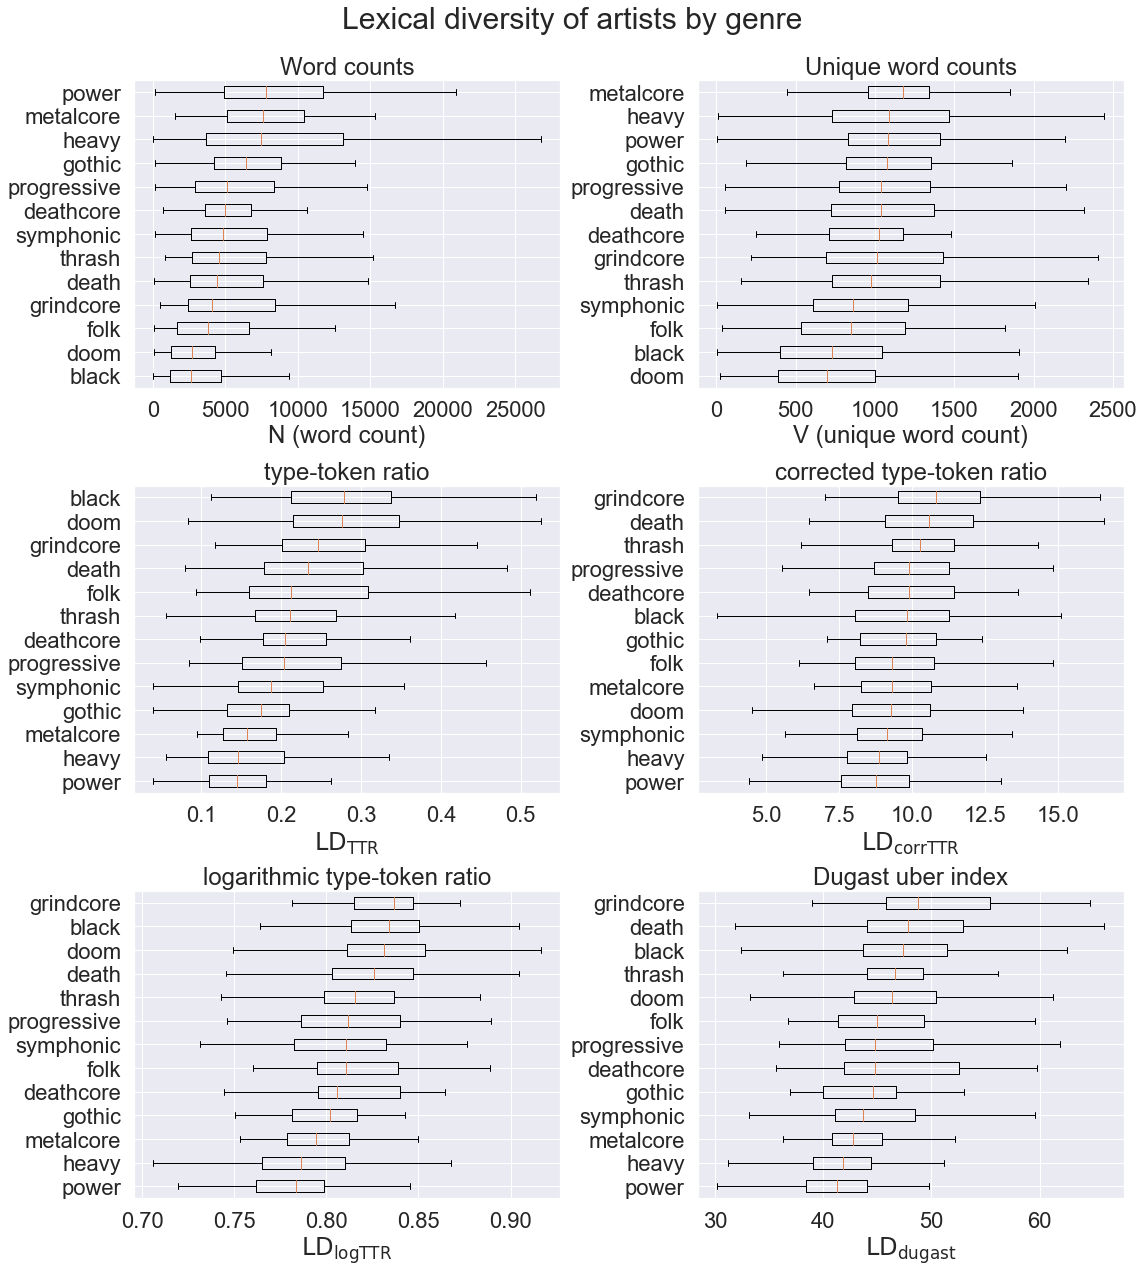

In [19]:
plot_boxplots(df_exp_bands)

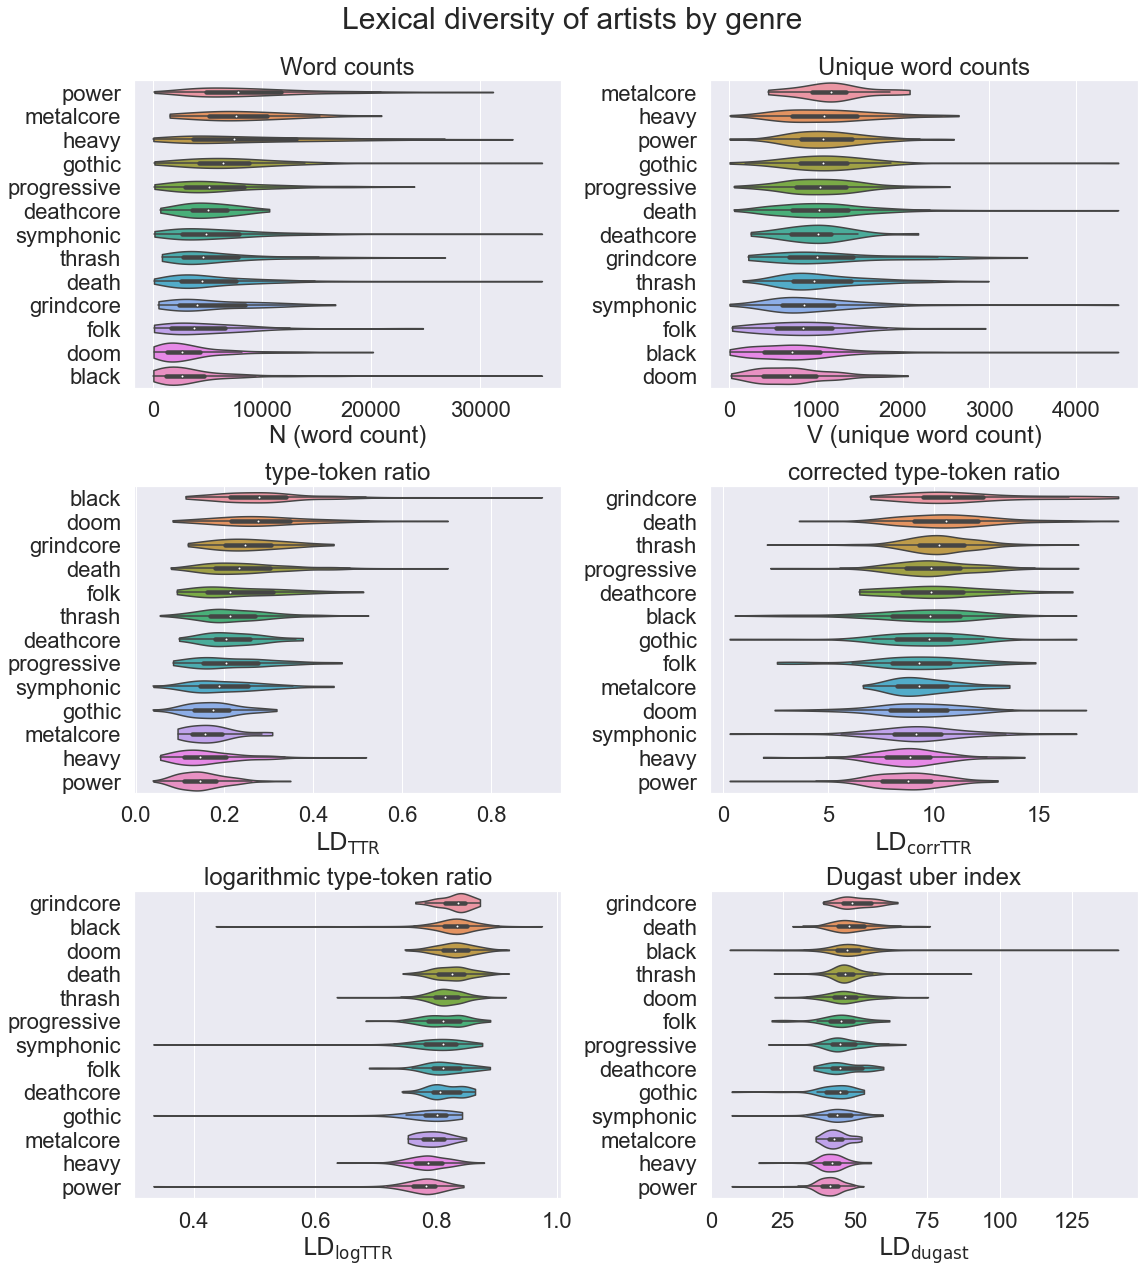

In [20]:
plot_violinplots(df_exp_bands)